# Explore formats to save images in

In [1]:
import os
import time
import numpy as np
import pandas as pd
import tensorflow as tf

from matplotlib import pyplot as plt
from PIL import Image
from pathlib import Path
from fastparquet import write, ParquetFile

# Plotting pretty figures and avoid blurry images
%config InlineBackend.figure_format = 'retina'

### Results

In [33]:
sizes_mb = {'numpy': 14.7, 'jpg': 4.6, 'parquete': 31.3}
time_sec = {'numpy':0.15, 'jpg':1, 'parquete':7.2}

features = [sizes_mb, time_sec]

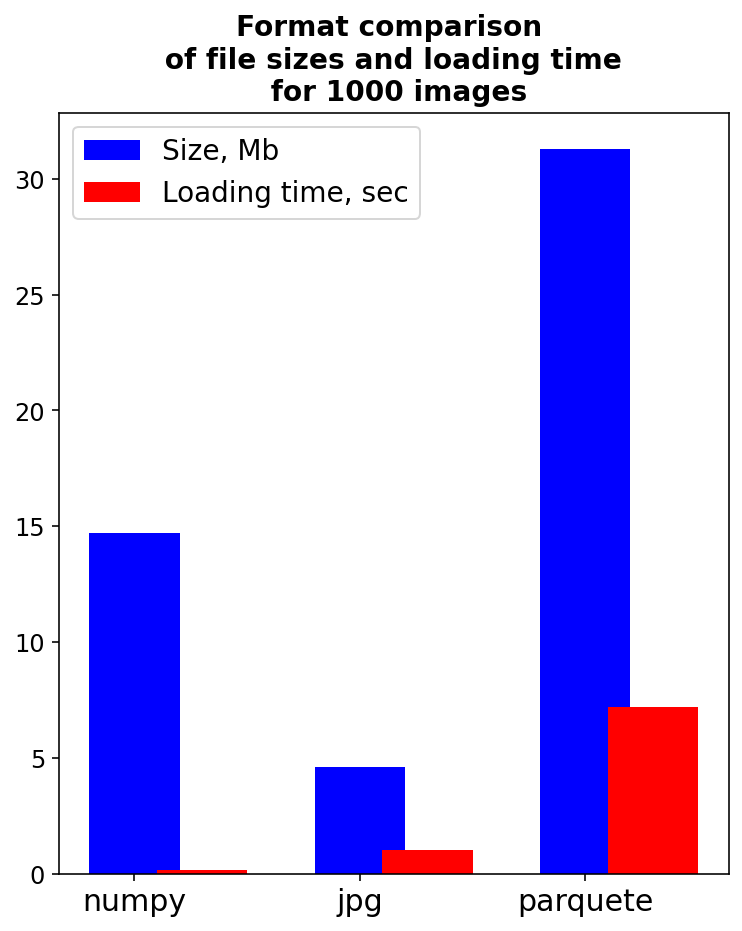

In [34]:
X_data = np.arange(len(features[0]))
labels = ['Size, Mb', 'Loading time, sec']
colors = 'br'
step = 0

fig, ax = plt.subplots(figsize=(6, 7))
for i, feature in enumerate(features):
    ax.bar(X_data + step, feature.values(), color = colors[i], width = 0.4, label=labels[i])
    step += 0.3

plt.title('Format comparison \n of file sizes and loading time \n for 1000 images', 
          size=14, fontweight='bold')
plt.xticks(X_data, time_sec.keys(), fontsize=15)
plt.yticks(fontsize=12)
plt.legend(prop={'size':14})
plt.show()

### Setup

In [2]:
def get_size(path):
    path = Path(path)
    if path.is_dir():
        byte_size = sum(f.stat().st_size for f in path.iterdir())
    else:
        byte_size = path.stat().st_size
        
    mb_size = byte_size / 1_000_000
    return f'{mb_size:.3f} Mb'

def display_car_price(X, y):
    num_images = 12
    
    plt.figure(figsize=(15, 5))
    for i, (img, price) in enumerate(zip(X[:num_images], y[:num_images])):
        ax = plt.subplot(2, 6, i + 1)    
        ax.imshow(img[:, :, 0], cmap='gray')
        ax.set_title(price)
        ax.axis('off')

In [3]:
# All images first resized to 'mid_size' without distortions
mid_size = (250, 380)
# than resized to 'final_size' with distortions
final_size = (128, 128)

csv_path = '../datasets/autoria/autoria_clean_data.csv'
df = pd.read_csv(csv_path)


def process_path(path):
    img = get_image(path)
    price = get_price(path)
    return img, price

def get_image(path):
    img = tf.keras.preprocessing.image.load_img(path, color_mode='grayscale')
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = tf.keras.preprocessing.image.smart_resize(img, mid_size)
    img = tf.image.resize(img, final_size)
    
    return img.numpy().astype(np.uint8)

def get_price(path):
    car_id = path.name.split('_', 1)[0]
    car_id = int(car_id)

    price = df.loc[df['id'] == car_id, 'price_USD'].values[0]
    
    return price

### Compare storage formats

#### Process 1000 images

In [4]:
img_dir = Path('../datasets/autoria/images')
img_paths = list(img_dir.iterdir())

In [5]:
start = time.perf_counter()

X = []
y = []
counter = 1
for path in img_paths[:1000]:
    img, price = process_path(path)
    X.append(img)
    y.append(price)
    
    if counter % 100 == 0:
        print('Done:', counter, end='\r')
    counter += 1
    
X = np.stack(X)
y = np.stack(y)
    
end = time.perf_counter()
print()
print(f'Time to read and process 1000 images: {end - start:.2f} seconds')

Done: 1000
Time to read and process 1000 images: 13.24 seconds


In [6]:
X.shape, y.shape

((1000, 128, 128, 1), (1000,))

In [7]:
# So, all images will take more than 20 minutes to preprocess
(140 * 9) / 60

21.0

In [8]:
X.dtype, y.dtype

(dtype('uint8'), dtype('int64'))

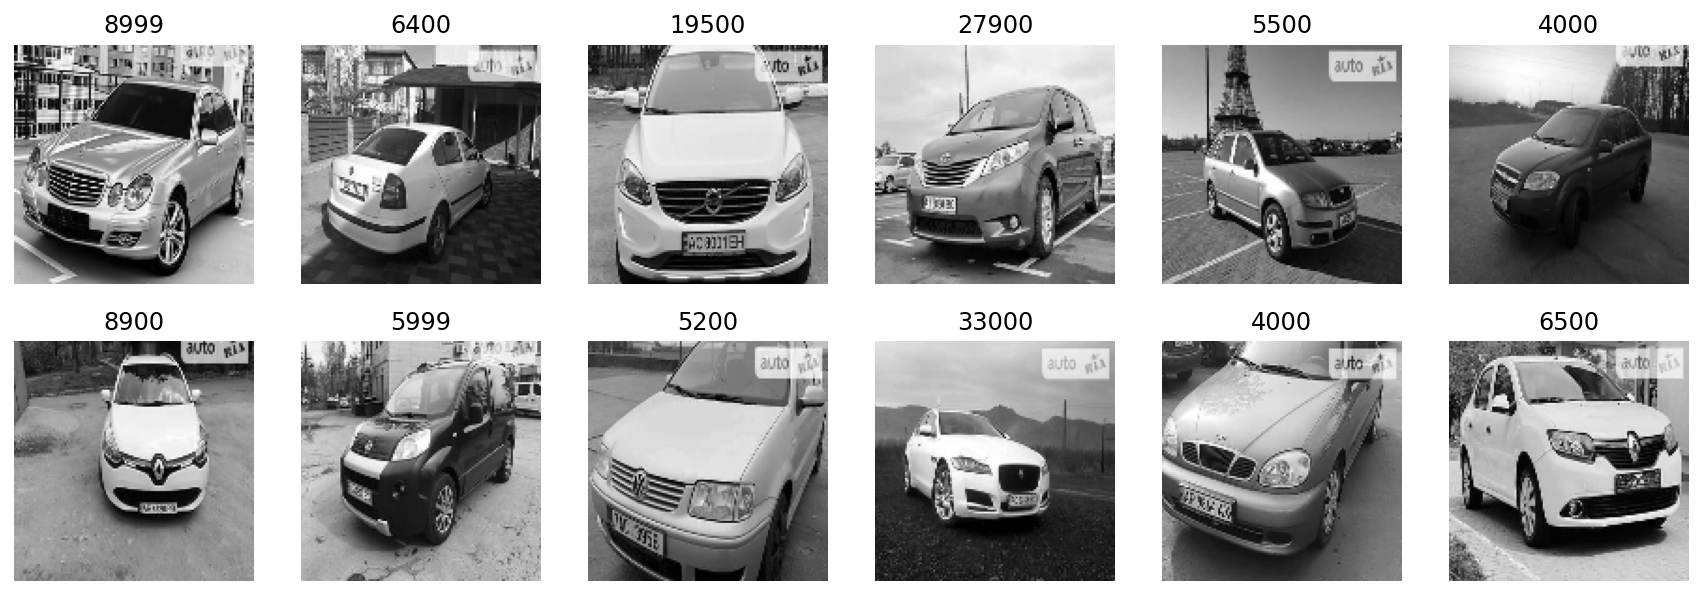

In [9]:
display_car_price(X, y)

#### Save with numpy

In [10]:
save_path_1k_numpy = '../datasets/autoria/ready/image_price_128_gray_int_1k.npz'

In [11]:
np.savez_compressed(save_path_1k_numpy, X=X, y=y)

In [12]:
get_size(save_path_1k_numpy)

'14.753 Mb'

##### Test loading saved file (numpy)

In [13]:
start = time.perf_counter()

from_numpy = np.load(save_path_1k_numpy)
X_np = from_numpy['X']
y_np = from_numpy['y']

end = time.perf_counter()
print(f'Load time: {end - start:.3f}')

Load time: 0.147


In [14]:
X_np.shape, y_np.shape

((1000, 128, 128, 1), (1000,))

In [15]:
(X_np == X).all()

True

#### Save as jpg

In [16]:
jpg_dir = Path('../datasets/autoria/ready/jpeg_1000/')

if not jpg_dir.exists():
    jpg_dir.mkdir()

In [17]:
start = time.perf_counter()

for i, img in enumerate(X):
    img = Image.fromarray(img[:, :, 0])
    img.save(jpg_dir/img_paths[i].name)
    
    if i % 100 == 0:
        print('Done:', i, end='\r')
        
end = time.perf_counter()
print(f'\nTime taken: {end - start:.3f}')

Done: 900
Time taken: 0.602


In [18]:
get_size(jpg_dir)

'4.612 Mb'

##### Test loading saved file (jpg)

In [19]:
start = time.perf_counter()

X_jpg = []
y_jpg = []

for path in jpg_dir.iterdir():
    img = tf.keras.preprocessing.image.load_img(path, color_mode='grayscale')
    price = get_price(path)
    X_jpg.append(img)
    y_jpg.append(price)
    
X_jpg = np.stack(X_jpg)
X_jpg = np.expand_dims(X_jpg, -1)
y_jpg = np.stack(y_jpg)

end = time.perf_counter()
print(f'Load time: {end - start:.3f}')

Load time: 1.060


In [20]:
X_jpg.shape, y_jpg.shape

((1000, 128, 128, 1), (1000,))

In [21]:
(X_jpg == X).all()

False

In [22]:
for x, x_jpg in zip(X[0, 0, :5], X_jpg[0, 0, :5]):
    print(x, x_jpg)

[8] [10]
[16] [4]
[248] [255]
[148] [159]
[135] [130]


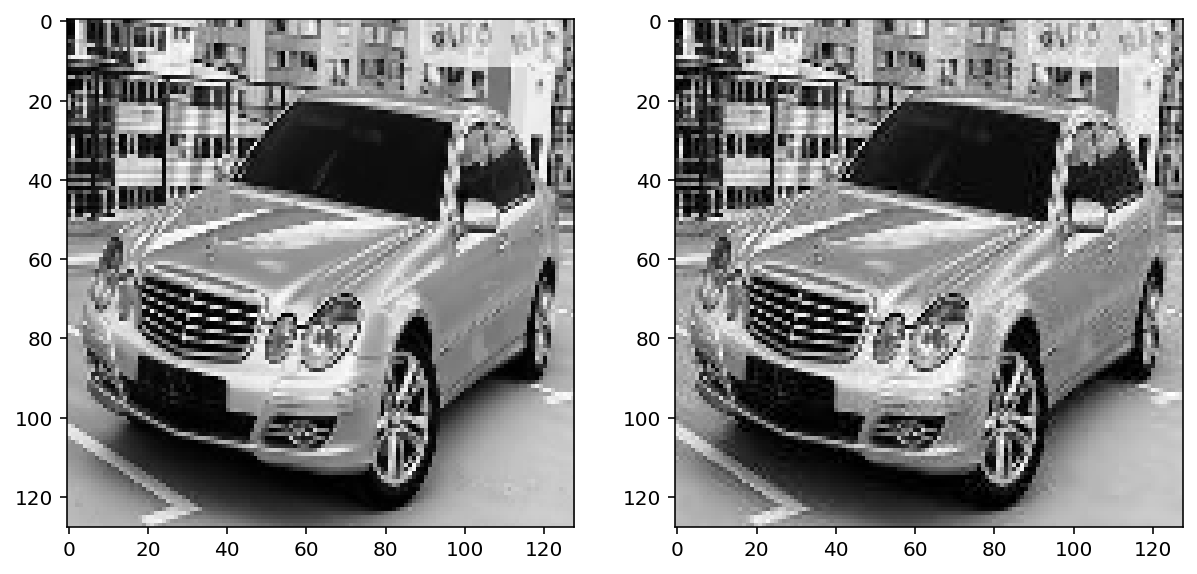

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(X[0][:, :, 0], cmap='gray')
ax2.imshow(X_jpg[0][:, :, 0], cmap='gray')

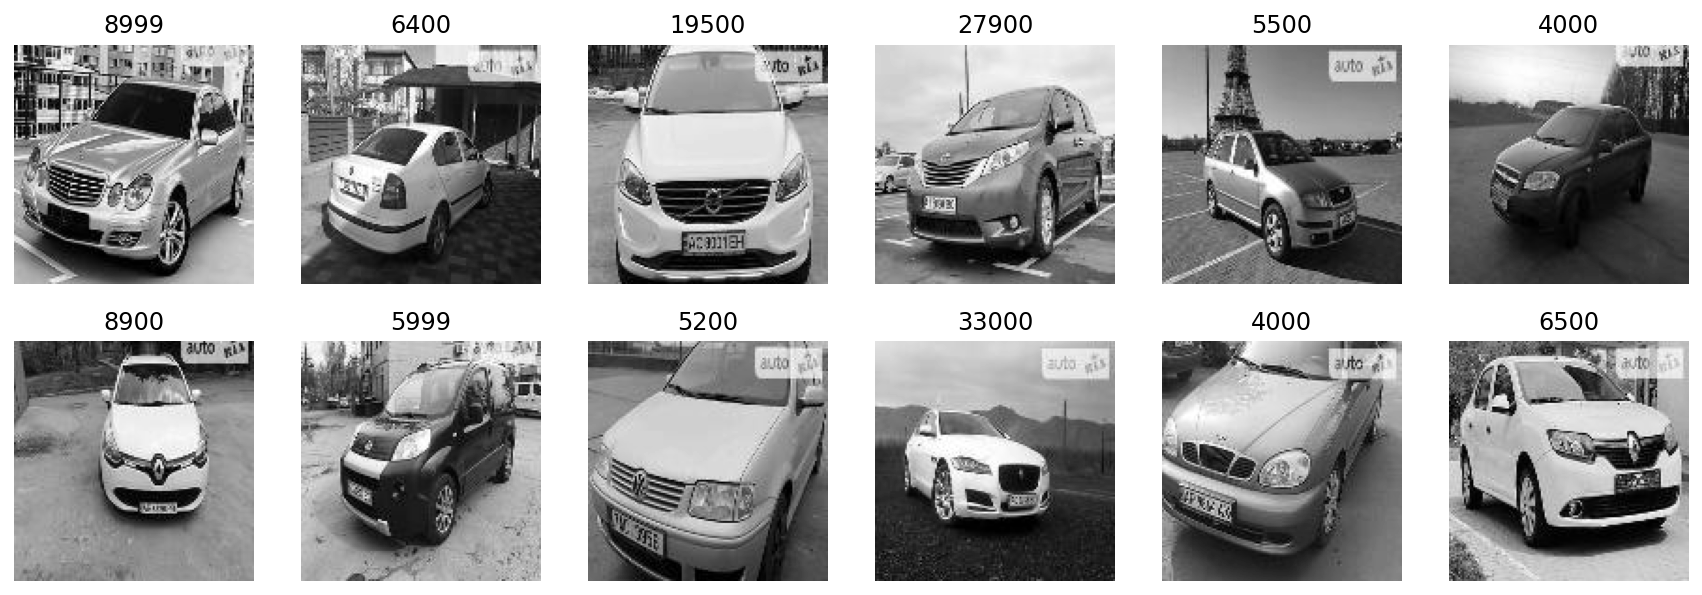

In [24]:
display_car_price(X_jpg, y_jpg)

#### Save parquet

In [25]:
save_path_1k_parq = '../datasets/autoria/ready/image_price_128_gray_int_1k_gzip.parq'

In [26]:
X_flat = np.stack([x.flatten() for x in X])
X_flat.shape

(1000, 16384)

In [27]:
df = pd.DataFrame((X_flat))
df.insert(0, 'y', y)
# parquet requires column names to be strings
df.columns = df.columns.map(str)
df

,y,0,1,2,3,4,5,6,7,8,...,16374,16375,16376,16377,16378,16379,16380,16381,16382,16383
0,8999,8,16,248,148,135,31,55,52,38,...,198,197,200,199,198,199,199,199,199,203
1,6400,151,177,163,173,169,157,147,176,127,...,33,33,33,32,32,32,39,39,38,39
2,19500,44,39,27,35,29,49,27,44,41,...,116,121,118,128,145,132,142,144,153,149
3,27900,210,211,212,212,212,213,214,215,214,...,117,117,96,93,92,96,82,90,88,98
4,5500,156,156,156,155,155,154,153,152,151,...,45,38,47,40,39,43,41,38,34,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,5300,17,20,21,16,18,24,18,19,21,...,2,2,2,2,2,2,2,2,2,2
996,1200,195,192,198,194,207,180,150,174,167,...,122,100,79,114,113,144,93,119,79,71
997,7699,231,232,233,233,233,233,235,235,233,...,79,75,80,88,89,94,78,101,93,88
998,6100,134,188,223,234,235,234,237,224,211,...,196,179,195,185,183,185,163,181,155,173


In [28]:
# saving as parquete
write(save_path_1k_parq, df, compression='GZIP')

In [29]:
get_size(save_path_1k_parq)

'31.312 Mb'

##### Test loading saved file (parquet)

In [30]:
start = time.perf_counter()

parq_df = ParquetFile(save_path_1k_parq).to_pandas()


y_parq = parq_df.loc[:, 'y'].values

X_parq = parq_df.iloc[:, 1:].values
X_parq = X_parq.reshape((1000, 128, 128, 1))

end = time.perf_counter()
print(f'Load time: {end - start:.3f}')

Load time: 8.334


In [31]:
X_parq.shape, y_parq.shape

((1000, 128, 128, 1), (1000,))

In [32]:
(X_parq == X).all()

True